In [1]:
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import itertools
import datetime
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
data_path = '../data-unversioned/p1ch6/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))


cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']

cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]

cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

augmentation = transforms.Compose([transforms.Pad(4, padding_mode='reflect') ,transforms.RandomHorizontalFlip(),transforms.RandomCrop(32),transforms.Normalize((0.4915, 0.4823, 0.4468),(0.2470, 0.2435, 0.2616))])


train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")



# Input ein Block
# Output ein Block
# dann die 26 Layer, um die 28 Blöcke zu haben

import torch
import torch.nn as nn
import torch.nn.functional as F

# wechseln: Batchnorm, Relu, Conv:

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride): # hier in und out-channels ändern
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.bn1(x)
        out = F.relu(out)
        out = self.conv1(out)
        out = self.bn2(out)
        out = F.relu(out)
        out = self.conv2(out)
        out += self.shortcut(residual)
        return out


class WRN(nn.Module):
    def __init__(self, depth, widen_factor, num_classes):
        super(WRN, self).__init__()
        assert (depth - 4) % 6 == 0, 'depth should be 6n+4'
        self.n = (depth - 4) // 6
        self.k = widen_factor
        self.in_channels = 16
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.layer1 = self._make_layer(16 * self.k, stride=1)
        self.layer2 = self._make_layer(32 * self.k, stride=2)
        self.layer3 = self._make_layer(64 * self.k, stride=2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64 * self.k, num_classes)

    def _make_layer(self, out_channels, stride):
        layers = []
        layers.append(BasicBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(self.n - 1):
            layers.append(BasicBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


model = WRN(depth=28, widen_factor=2, num_classes=2)

if torch.cuda.is_available():
  model.cuda()

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    loss_train_3 = np.zeros(n_epochs)
    loss_val_3 = np.zeros(n_epochs)
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = augmentation(imgs)
            imgs, labels = imgs.to(device=device), labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        loss_train_3[epoch-1] = loss_train/len(train_loader)

        loss_val = 0.0
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device=device), labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            loss_val += loss.item()

        loss_val_3[epoch-1] = loss_val/len(val_loader)

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))
            print('{} Epoch {}, Validation loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_val / len(val_loader)))
    return loss_train_3, loss_val_3

optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

loss_train_3,loss_val_3 = training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

all_acc_dict = collections.OrderedDict()

def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

all_acc_dict["baseline"] = validate(model, train_loader, val_loader)

sum(p.numel() for p in model.parameters())

100%|██████████| 170498071/170498071 [00:13<00:00, 13036631.68it/s]


Extracting ../data-unversioned/p1ch6/cifar-10-python.tar.gz to ../data-unversioned/p1ch6/
Files already downloaded and verified
Training on device cuda.
2023-06-19 06:53:34.507896 Epoch 1, Training loss 0.4813856057300689
2023-06-19 06:53:34.508773 Epoch 1, Validation loss 0.41500903852283955
2023-06-19 06:54:25.590058 Epoch 10, Training loss 0.27250495576744627
2023-06-19 06:54:25.590177 Epoch 10, Validation loss 0.27208201587200165
2023-06-19 06:55:24.319519 Epoch 20, Training loss 0.2051739419816406
2023-06-19 06:55:24.319676 Epoch 20, Validation loss 0.2194813636597246
2023-06-19 06:56:23.466401 Epoch 30, Training loss 0.16257329377683866
2023-06-19 06:56:23.466542 Epoch 30, Validation loss 0.24910346185788512
2023-06-19 06:57:22.537852 Epoch 40, Training loss 0.14134696216150455
2023-06-19 06:57:22.537983 Epoch 40, Validation loss 0.19938630843535066
2023-06-19 06:58:21.595968 Epoch 50, Training loss 0.11244227501095101
2023-06-19 06:58:21.596083 Epoch 50, Validation loss 0.174741

1466802

<function matplotlib.pyplot.show(close=None, block=None)>

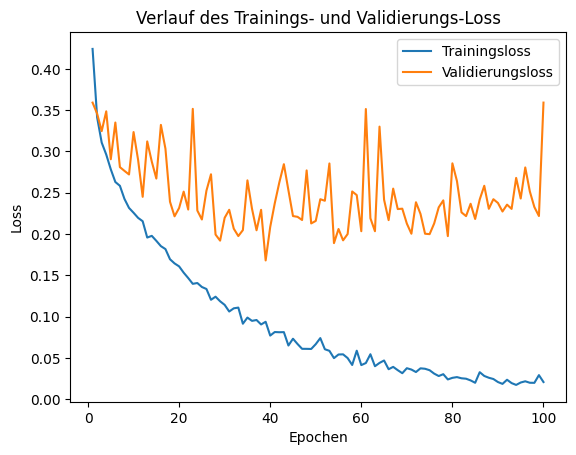

In [ ]:
epochs = np.arange(1, 101, 1)

plt.plot(epochs, loss_train_3, label = 'Trainingsloss')
plt.plot(epochs, loss_val_3, label = 'Validierungsloss')
plt.xlabel("Epochen")
plt.ylabel("Loss")
plt.legend()
plt.title("Verlauf des Trainings- und Validierungs-Loss")
plt.show

Vergleicht man die Accuracy für Trainings- und Validierungsdaten mit dem Beispiel aus dem Buch, fällt auf, dass der Validierungsloss bei zunehmenden Epochen wieder eine steigende Tendenz hat. Zudem ist weiterhin ein Übertraining zu erkennen. Nimmt man das "Res" als Referenz (Train-Loss: ca. 97 und Val-Loss: ca. 89) erkennt man, dass bei uns der Validierungsloss höher ist und somit weniger Übertreining besteht.

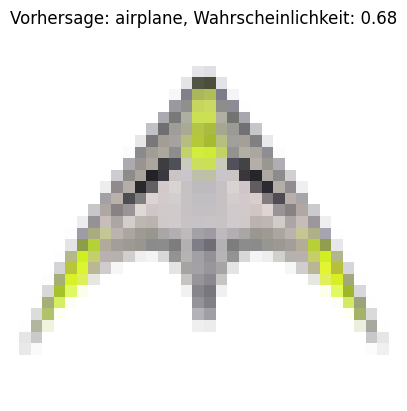

In [ ]:
import numpy as np
from PIL import Image
import torch

image = Image.open('Lenkdrache2.jpg')

resized_image = image.resize((32, 32))

image_resized = np.array(resized_image)

tensor = torch.from_numpy(image_resized)

tensor = tensor.permute(2, 0, 1).float().to(device = device)

output = model(tensor.unsqueeze(0))
output = F.softmax(output,dim=1)
confi, predicted = torch.max(output, dim=1)

label_dragon = class_names[predicted.item()]
confi_dragon = confi.item()


plt.imshow(image_resized)
plt.title(f"Vorhersage: {label_dragon}, Wahrscheinlichkeit: {confi_dragon:.2f}")
plt.axis('off')
plt.show()